In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\beama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
# import data
sent = pd.read_csv('AmazonReview.csv')
sent.head()

,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


### Data

In [83]:
sent.info()

# check for missing values
sent.isnull().sum()
# drop missing values
sent.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [84]:
sent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24999 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  24999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


Text(0.5, 1.0, 'Distribution of the number of stars')

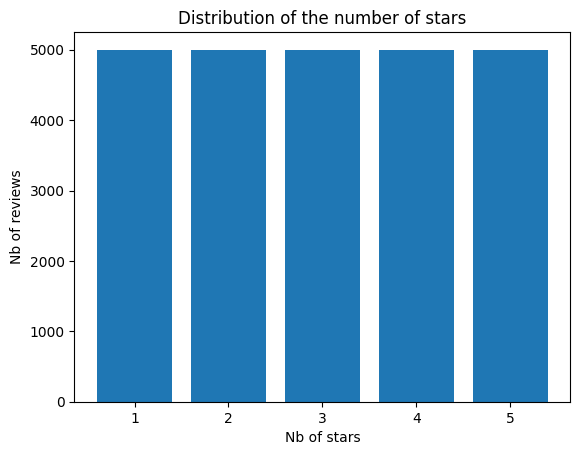

In [85]:
# count the sentiment column

counts = sent.value_counts('Sentiment')
#print(counts)

# bar plots of the number of star reviews

plt.bar(counts.index, counts.values)
plt.xlabel('Nb of stars')
plt.ylabel('Nb of reviews')
plt.title('Distribution of the number of stars')


In [86]:
# reviews with less than 3 stars are negative --> label 0
# reviews with 4 or 5 stars are positive --> label 1

sent['Sentiment'] = sent['Sentiment'].apply(lambda x: 0 if x <= 3 else 1)

In [87]:
# remove stopwords 
stop = stopwords.words('english')
sent['Review'] = sent['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [88]:
sent.head()

,Review,Sentiment
0,Fast shipping product cheaply made I brought g...,0
1,This case takes long ship even worth DONT BUY!!!!,0
2,Good droids. Not good iPhones. You cannot use ...,0
3,The cable compatible macbook iphone. Also conn...,0
4,The case nice glow light. I'm disappointed pro...,0


In [89]:
# check counts again 
counts = sent.value_counts('Sentiment')
# print(counts)

In [90]:
# td-idf is used to check how relevant a word is
# the td-idf score is given by the product of the term frequency and the inverse document frequency

vect = TfidfVectorizer(max_features=2500) # keep only the 2500 most frequent words
X = vect.fit_transform(sent['Review']).toarray() # matrix of features where each row is a review and each column is a word and the value is the tf-idf score

In [91]:
# check feature names 
features = vect.get_feature_names_out() 
#print(features)

### Model training

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [93]:
# train test split

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,sent['Sentiment'], test_size=0.2, random_state=0)

#### Logistic Regression

In [95]:
# using nested CV to estimate the C parameter 

model2tune = LogisticRegression(max_iter=10000, random_state=0)

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC

innercv = KFold(n_splits=5, shuffle=True, random_state=0)
outercv = KFold(n_splits=3, shuffle=True, random_state=0)
params =  {'C': [0.1, 1, 10, 100, 1000]}

model = GridSearchCV(model2tune, params, cv=innercv, scoring='accuracy')

scores = cross_val_score(model, xtrain, ytrain, cv=outercv, scoring='accuracy')


In [96]:
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.817 (0.005)


In [97]:
model.fit(xtrain, ytrain)
#print(model.best_params_)

{'C': 1}


In [99]:
pred = model.predict(xtest)
from sklearn.metrics import accuracy_score
print('The test accuracy is: ', accuracy_score(ytest, pred))

The test accuracy is:  0.814


In [100]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(ytest, pred))
#print(classification_report(ytest, pred))

[[2640  340]
 [ 590 1430]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2980
           1       0.81      0.71      0.75      2020

    accuracy                           0.81      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.81      0.81      5000



#### SVM